Bài 1:

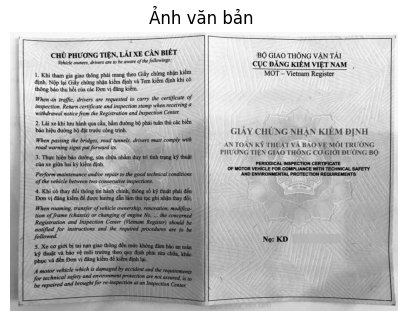

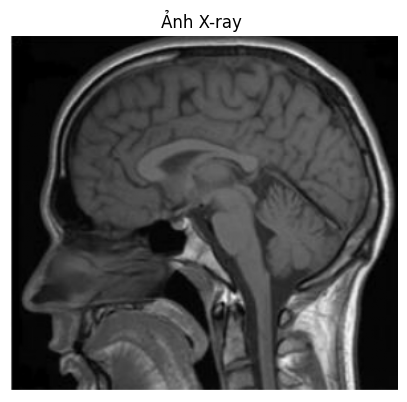

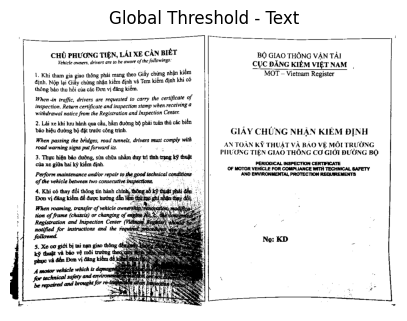

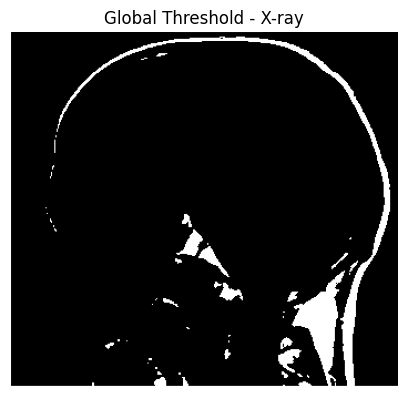

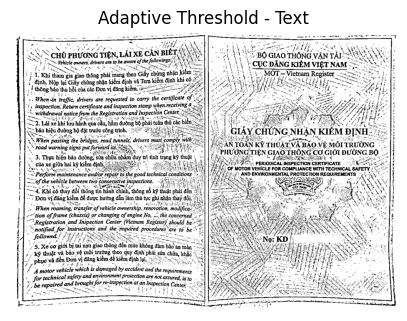

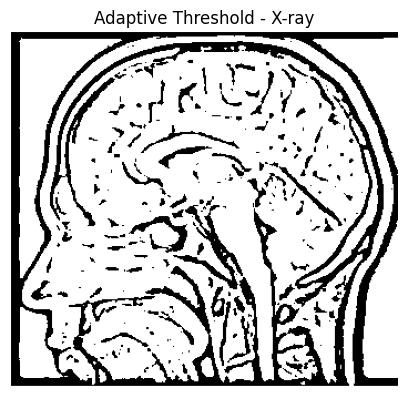

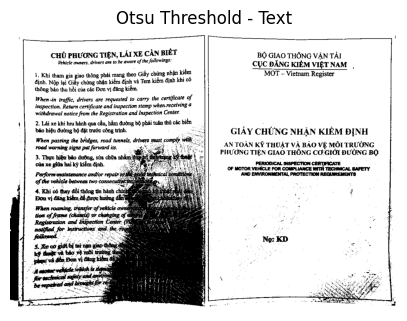

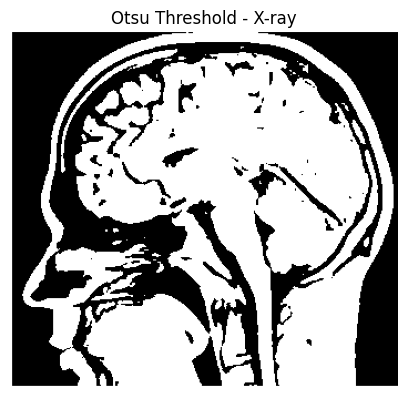

In [2]:
def show(title, img):
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# ===============================
#  HÀM TÍNH IoU
# ===============================
def IoU(pred, gt):
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    intersection = np.logical_and(pred_bin, gt_bin).sum()
    union = np.logical_or(pred_bin, gt_bin).sum()
    return intersection / union if union != 0 else 0

# ===============================
#  ĐỌC ẢNH
# ===============================
img_text = cv2.imread("/content/drive/MyDrive/Colab Notebooks/vanban.jpg", 0)
img_xray  = cv2.imread("/content/drive/MyDrive/Colab Notebooks/SKULL.png", 0)

show("Ảnh văn bản ", img_text)
show("Ảnh X-ray ", img_xray)

# ===============================
#  1. GLOBAL
# ===============================
_, global_text = cv2.threshold(img_text, 127, 255, cv2.THRESH_BINARY)
_, global_xray = cv2.threshold(img_xray, 127, 255, cv2.THRESH_BINARY)

show("Global Threshold - Text", global_text)
show("Global Threshold - X-ray", global_xray)

# ===============================
#  2. ADAPTIVE THRESHOLDING
# ===============================
adaptive_text = cv2.adaptiveThreshold(
    img_text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 25, 10)

adaptive_xray = cv2.adaptiveThreshold(
    img_xray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 25, 10)

show("Adaptive Threshold - Text", adaptive_text)
show("Adaptive Threshold - X-ray", adaptive_xray)

# ===============================
#  3. OTSU THRESHOLDING
# ===============================
_, otsu_text = cv2.threshold(
    img_text, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, otsu_xray = cv2.threshold(
    img_xray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show("Otsu Threshold - Text", otsu_text)
show("Otsu Threshold - X-ray", otsu_xray)




Bài 2:

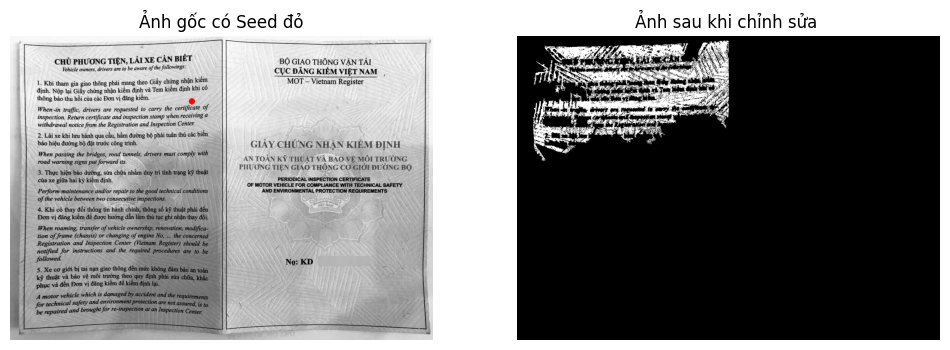

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold=10, use_8_neighbors=True):
    h, w = image.shape
    seed_value = image[seed[1], seed[0]]

    segmented = np.zeros((h, w), np.uint8)
    visited = np.zeros((h, w), np.uint8)

    queue = [(seed[0], seed[1])]
    visited[seed[1], seed[0]] = 1

    if use_8_neighbors:
        neighbors = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    else:
        neighbors = [(-1,0),(1,0),(0,-1),(0,1)]

    while queue:
        x, y = queue.pop(0)

        for dx, dy in neighbors:
            xx, yy = x + dx, y + dy

            if 0 <= xx < w and 0 <= yy < h and not visited[yy, xx]:
                visited[yy, xx] = 1

                if abs(int(image[yy, xx]) - int(seed_value)) < threshold:
                    segmented[yy, xx] = 255
                    queue.append((xx, yy))

    return segmented


# ====== LOAD ẢNH ======
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/vanban.jpg", 0)

seed = (550, 200)
threshold = 15

seg = region_growing(img, seed, threshold, use_8_neighbors=True)

# ====== VẼ CHẤM ĐỎ ĐÁNH DẤU SEED ======
img_mark = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.circle(img_mark, seed, 4, (255, 0, 0), 10)   # chấm đỏ (R,G,B)


# ====== HIỂN THỊ ======
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Ảnh gốc có Seed đỏ")
plt.imshow(img_mark)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Ảnh sau khi chỉnh sửa ")
plt.imshow(seg, cmap="gray")
plt.axis("off")

plt.show()


bài 3:

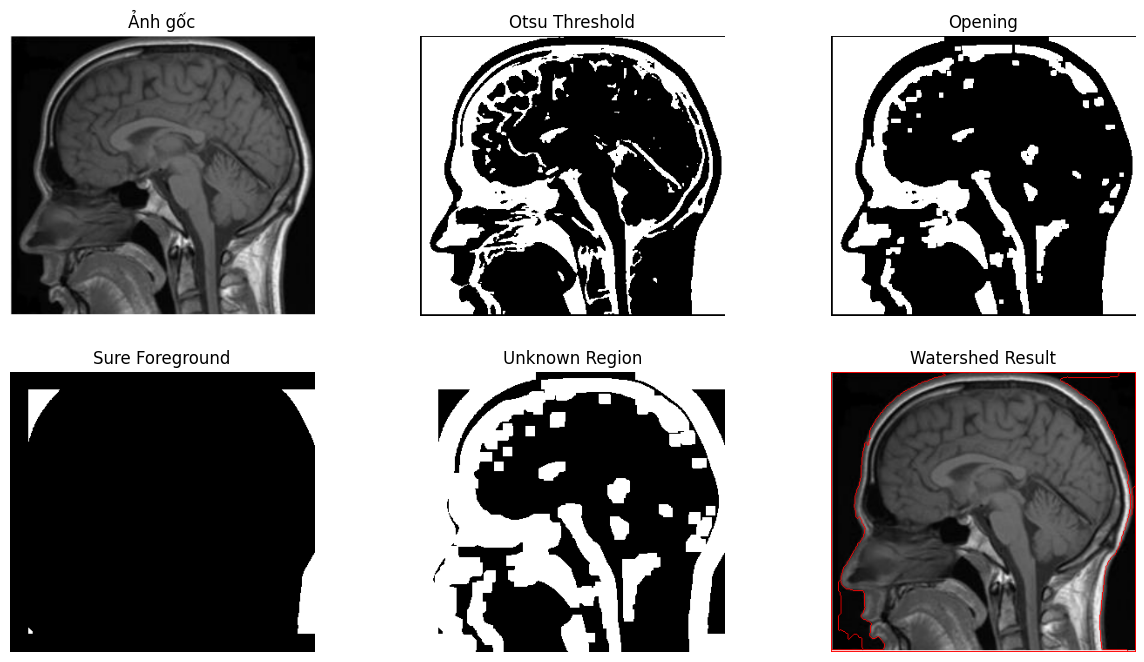

In [11]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/SKULL.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background (dãn nở – background lớn)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret_fg, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

img_watershed = img.copy()
img_watershed[markers == -1] = [0, 0, 255]   # vẽ biên màu đỏ

plt.figure(figsize=(15,8))

plt.subplot(2,3,1); plt.title("Ảnh gốc"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(2,3,2); plt.title("Otsu Threshold"); plt.imshow(thresh, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Opening"); plt.imshow(opening, cmap="gray"); plt.axis("off")
plt.subplot(2,3,4); plt.title("Sure Foreground"); plt.imshow(sure_fg, cmap="gray"); plt.axis("off")
plt.subplot(2,3,5); plt.title("Unknown Region"); plt.imshow(unknown, cmap="gray"); plt.axis("off")
plt.subplot(2,3,6); plt.title("Watershed Result"); plt.imshow(cv2.cvtColor(img_watershed, cv2.COLOR_BGR2RGB)); plt.axis("off")

plt.show()


Bài 4:



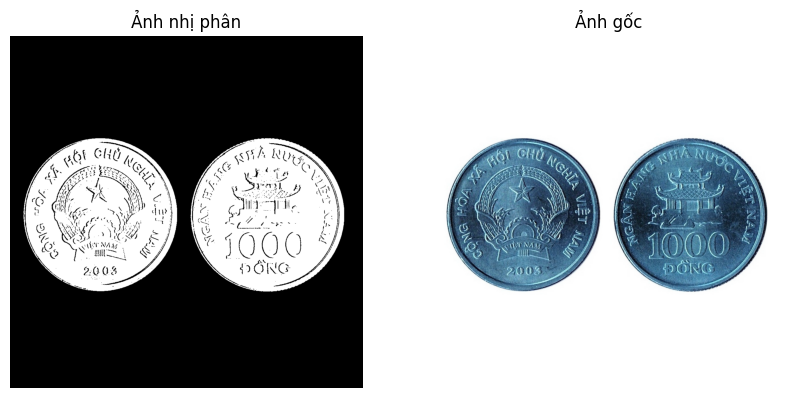

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img=cv2.imread("/content/drive/MyDrive/Colab Notebooks/xu.jpg")
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(gray,0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(binary_img, cmap='gray')
plt.axis('off')
plt.title('Ảnh nhị phân')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('Ảnh gốc')
plt.axis('off')
plt.show()

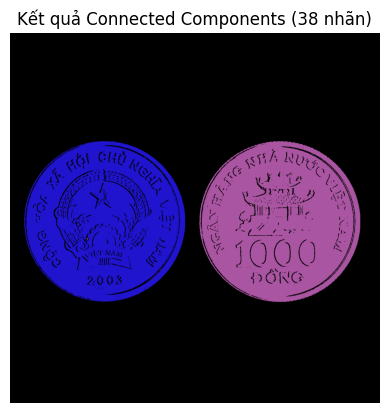

Tổng số vùng liên thông (bao gồm nền): 38
Kiểu dữ liệu của ảnh nhãn: int32


In [ ]:
# 1. Áp dụng cv2.connectedComponents cho anh nhi phan
num_labels, labels_img = cv2.connectedComponents(binary_img)
# 2. Xử lý và Hiển thị kết quả
# Tạo một ảnh màu để visualize các nhãn (tạo màu ngẫu nhiên cho từng đối tượng)
output_cc = np.zeros((binary_img.shape[0], binary_img.shape[1],3), dtype=np.uint8)
# Bỏ qua nhãn 0 (nền den) i=0,1,2,3
for i in range(1, num_labels):
    # Tạo màu ngẫu nhiên (BGR)
    color = np.random.randint(0, 255, 3).tolist()
    # Gán màu cho tất cả các pixel thuộc nhãn i
    output_cc[labels_img == i] = color

plt.imshow(cv2.cvtColor(output_cc, cv2.COLOR_BGR2RGB))
plt.title(f'Kết quả Connected Components ({num_labels} nhãn)')
plt.axis('off')
plt.show()
print(f"Tổng số vùng liên thông (bao gồm nền): {num_labels}")
print(f"Kiểu dữ liệu của ảnh nhãn: {labels_img.dtype}") # Thường là int32

Số lượng Contour được tìm thấy: 2


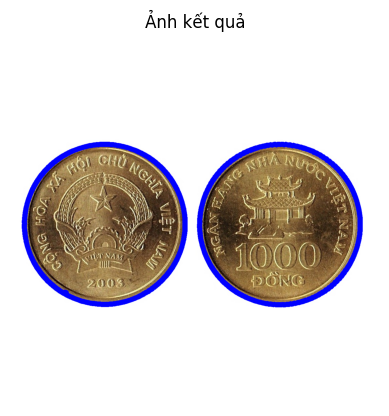

In [ ]:
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Số lượng Contour được tìm thấy: {len(contours)}")

output = img.copy()
# Vẽ tất cả các contour đã trích xuất
# Tham số 2: Các contour
# Tham số 3: Chỉ số contour cần vẽ (-1 để vẽ tất cả)
# Tham số 4: Màu sắc (BGR: 0, 255, 0 là màu xanh lá)
# Tham số 5: Độ dày của đường vẽ
out_img=cv2.drawContours(output, contours, -1, (255,0,0), 15)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh kết quả')
plt.axis('off')
plt.show()

In [ ]:

output_file = 'contour-output.txt'

# Mở file và ghi dữ liệu
with open(output_file, 'w') as f:
  for i , contours in enumerate(contours):
    f.write(f"\n--- CONTOUR  ({contours.shape[0]} diem) ---\n")
    for pnt in contours:
      f.write(f"{pnt[0][0]} {pnt[0][1]}\n")

print(f"xuat file contour thanh cong {output_file}")


xuat file contour thanh cong contour-output.txt


In [ ]:
# (không cần bỏ vào ppt , phần nay để ktra file co đúng không )

# có thể chup 1 phần kết quả dãy số dưới để so sánh bài 5

with open(output_file, 'r') as f:
        print(f"--- NỘI DUNG FILE: {output_file} ---")

        # Đọc toàn bộ nội dung file
        content = f.read()

        # In nội dung ra màn hình
        print(content)

--- NỘI DUNG FILE: contour-output.txt ---

--- CONTOUR  (770 diem) ---
855 351
853 353
847 353
846 352
844 352
843 353
841 353
840 354
831 354
830 355
829 355
827 357
825 357
824 356
823 356
822 357
818 357
816 359
809 359
808 360
806 360
805 361
804 361
802 363
801 363
800 362
798 364
797 363
795 363
794 364
793 364
790 367
784 367
783 368
782 368
781 369
781 370
780 371
774 371
773 372
771 372
767 376
764 376
763 377
760 377
756 381
755 381
754 382
752 382
751 383
749 383
744 388
740 388
738 390
737 390
733 394
732 394
730 396
729 396
728 397
726 397
726 398
724 400
723 400
721 402
720 402
719 403
718 403
710 411
708 411
704 415
704 416
703 417
702 417
700 419
699 419
694 424
694 425
693 426
692 426
689 429
688 429
688 430
687 431
687 432
684 435
683 435
682 436
682 437
681 438
680 438
679 439
679 440
678 441
678 442
671 449
671 450
668 453
668 454
663 459
663 461
660 464
660 465
657 468
657 469
655 471
655 473
652 476
652 477
650 479
650 480
649 481
649 483
648 484
648 485
646 487
6

Phần mở rộng : bouding bõ và convex hull

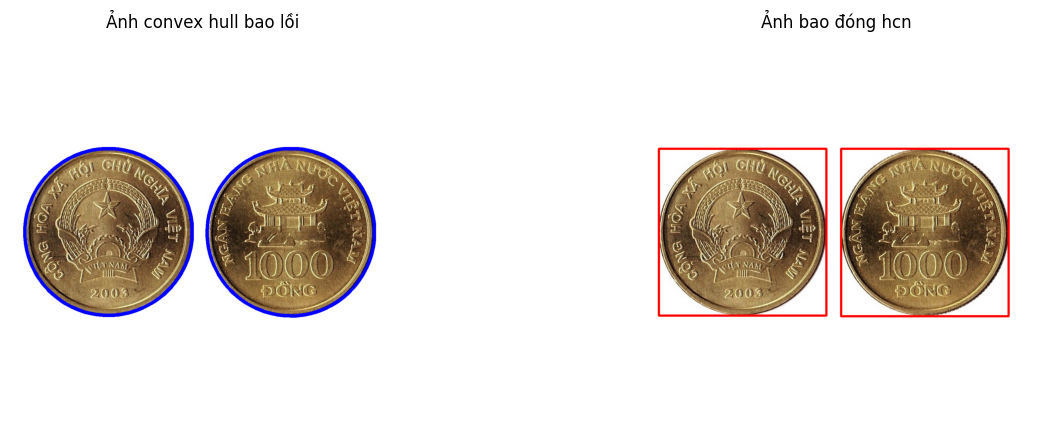

In [ ]:

# Tìm contours
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Tạo ảnh trống cùng kích thước ảnh gốc (thay cho thresh)
drawing_1 = img.copy()
drawing_2 = img.copy()
# Danh sách chứa diem bao loi cho từng contour
hull = [cv2.convexHull(cnt, False) for cnt in contours]

# Vẽ contour và convex hull
for i in range(len(contours)):
    cv2.polylines(drawing_1, [hull[i]], isClosed=True, color=(255,0,0), thickness=10)

for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(drawing_2, (x, y), (x+w, y+h), (0, 0, 255), 5)


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(drawing_1, cv2.COLOR_BGR2RGB))
plt.title('Ảnh convex hull bao lồi')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(drawing_2, cv2.COLOR_BGR2RGB))
plt.title('Ảnh bao đóng hcn')
plt.axis('off')

plt.show()

Bài 5:


In [ ]:

def freeman_chain_code_8(contours):
    chain_code_8 = []
    for contour in contours:
        if len(contour) < 2:
            continue  # bỏ contour nhỏ
        for i in range(1, len(contour)):
            x1, y1 = contour[i - 1][0]
            x2, y2 = contour[i][0]

            dx = np.sign(x2 - x1)
            dy = np.sign(y1 - y2)

            code = -1
            if dx == 1 and dy == 0:
                code = 0   # →
            elif dx == 1 and dy == -1:
                code = 1   # ↗
            elif dx == 0 and dy == -1:
                code = 2   # ↑
            elif dx == -1 and dy == -1:
                code = 3   # ↖
            elif dx == -1 and dy == 0:
                code = 4   # ←
            elif dx == -1 and dy == 1:
                code = 5   # ↙
            elif dx == 0 and dy == 1:
                code = 6   # ↓
            elif dx == 1 and dy == 1:
                code = 7   # ↘

            if code != -1:
                chain_code_8.append(code)
    return chain_code_8

# Ví dụ chạy:
chain_codes = freeman_chain_code_8(contours)
print("freeman 8 hướng (10 giá trị đầu):", chain_codes[:10])


freeman 8 hướng (10 giá trị đầu): [3, 4, 5, 4, 3, 4, 3, 4, 3, 4]


Phần mở rộng :Chữ viết tay


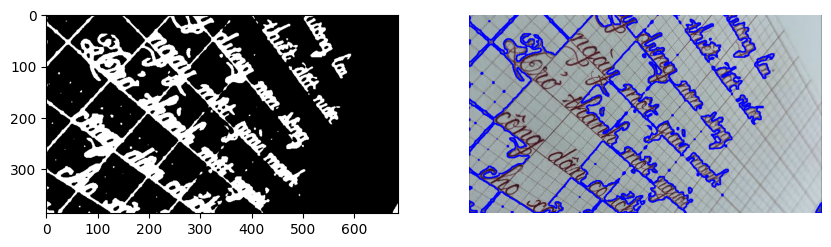

freeman 8 huong cuâ hinh handwrting : [2, 3, 2, 0, 0, 0, 6, 5, 2, 2]


In [ ]:
handw=cv2.imread("/content/drive/MyDrive/Colab Notebooks/handwriting.jpg")
hand_gray=cv2.cvtColor(handw,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(hand_gray, (11,11), 0)
_, binary_img_hand = cv2.threshold(blur,0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

contours_hand, hierarchy = cv2.findContours(binary_img_hand, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
hand = handw.copy()
cv2.drawContours(hand, contours_hand, -1, (255, 0, 0), 1)
canvas =cv2.drawContours(hand, contours_hand, -1, (0, 0, 255), 2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(binary_img_hand, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(canvas)
plt.axis('off')
plt.show()

# print(contours_hand[0][:10])
print("freeman 8 huong cuâ hinh handwrting :",freeman_chain_code_8(contours_hand)[:10])




Bài 6: Ứng dụng thực tế liên ngành

 Y tế: tách khối u trong ảnh MRI, đếm tế bào máu.

• Nông nghiệp: đếm số quả, phát hiện sâu bệnh trên lá.

• Giao thông: phát hiện biển số xe, vạch kẻ đường.

• An ninh: nhận diện khuôn mặt, tách người ra khỏi nền.

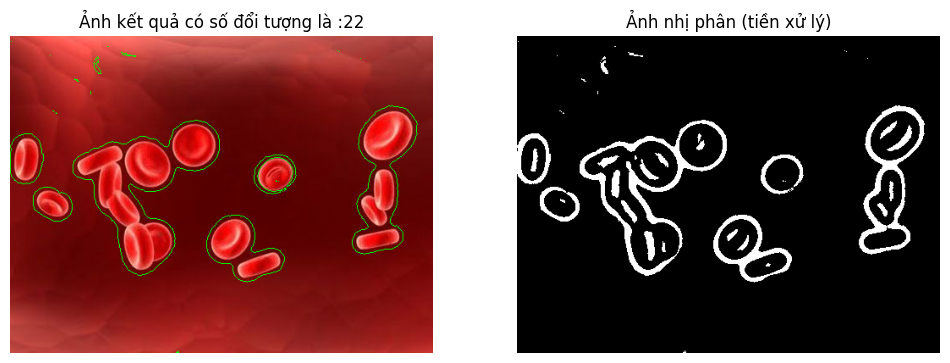

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def apdung(duong_dan_anh):
    anh_goc = cv2.imread(duong_dan_anh)
    # 2. Tiền xử lý
    anh_xam = cv2.cvtColor(anh_goc, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(
    clipLimit=2.0,
    tileGridSize=(8, 8) # Kích thước lưới (grid) mà CLAHE tính toán cục bộ
    )
    anh_clahe = clahe.apply(anh_xam)

# 3. Làm mờ để giảm nhiễu trên ảnh đã được CLAHE (Quan trọng)
# Dùng Median Blur để bảo tồn các cạnh tốt hơn
    anh_mo = cv2.medianBlur(anh_clahe, 13)

    # anh_mo = cv2.medianBlur(anh_xam, 13)
    anh_nhi_phan = cv2.adaptiveThreshold(anh_mo, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 27,8
    # Kích thước khối (Block Size): Kích thước vùng lân cận để tính ngưỡng
    # C (Constant): Giá trị trừ đi từ ngưỡng trung bình/Gaussian.
    # Giá trị dương nhỏ (ví dụ 4-8) giúp tách biên tốt hơn
)
    # 3. Tìm contour
    contours, _ = cv2.findContours(anh_nhi_phan, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 4. Vẽ contour lên ảnh gốc
    anh_ket_qua = anh_goc.copy()
    cv2.drawContours(anh_ket_qua, contours, -1, (0, 255, 0), 1)

    #đếm contour
    so = len(contours)

    # 6. Hiển thị kết quả
    anh_ket_qua_rgb = cv2.cvtColor(anh_ket_qua, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(anh_ket_qua_rgb)
    plt.title(f"Ảnh kết quả có số đổi tượng là :{so}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(anh_nhi_phan, cmap='gray')
    plt.title("Ảnh nhị phân (tiền xử lý)")
    plt.axis('off')

    plt.show()



# --- Chạy hàm ---
tebao = "/content/drive/MyDrive/Colab Notebooks/blood.jpg"
so = apdung(tebao)




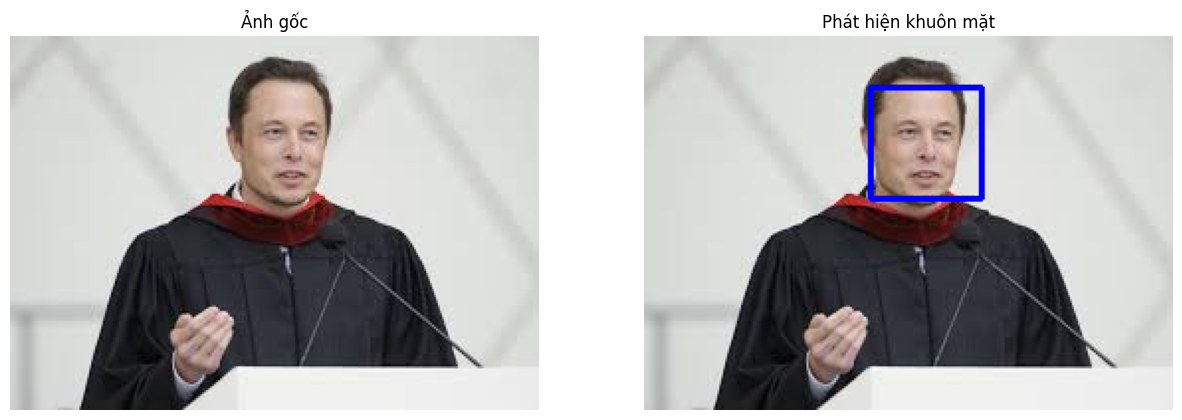

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background_with_contours(image, roi):
    # Cắt vùng ROI
    roi_image = image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

    # Chuyển sang gray và áp dụng Canny để tìm cạnh
    gray_roi = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_roi, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Chọn contour lớn nhất (giả định là người)
    largest_contour = max(contours, key=cv2.contourArea)

    # Tạo mask từ contour (
    mask = np.zeros_like(gray_roi)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=-1)

    # Mở rộng mask về kích thước ảnh gốc
    full_mask = np.zeros(image.shape[:2], np.uint8)
    full_mask[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] = mask

    # Áp dụng mask lên ảnh gốc
    result = image * (full_mask[:, :, np.newaxis] // 255)

    # Vẽ viền contour lên ảnh kết quả (viền màu xanh lá)
    cv2.drawContours(result, [largest_contour + np.array([roi[0], roi[1]])], -1, (0, 255, 0), 2)

    return result, full_mask

# Đọc ảnh đầu vào
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/elon.jpg")

# Phát hiện khuôn mặt bằng Haar cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

x, y, w, h = faces[0]

roi_x = max(0, x - w // 2)
roi_y = max(0, y - h // 2)
roi_w = min(image.shape[1] - roi_x, w * 2)
roi_h = min(image.shape[0] - roi_y, h * 15)
roi = (roi_x, roi_y, roi_w, roi_h)



# Hiển thị bằng matplotlib (chuyển BGR sang RGB cho plt)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ảnh gốc
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')

# Ảnh với khuôn mặt được đánh dấu
face_detected = image.copy()
cv2.rectangle(face_detected, (x, y), (x+w, y+h), (255, 0, 0), 2)
axes[1].imshow(cv2.cvtColor(face_detected, cv2.COLOR_BGR2RGB))
axes[1].set_title('Phát hiện khuôn mặt')
axes[1].axis('off')


plt.show()



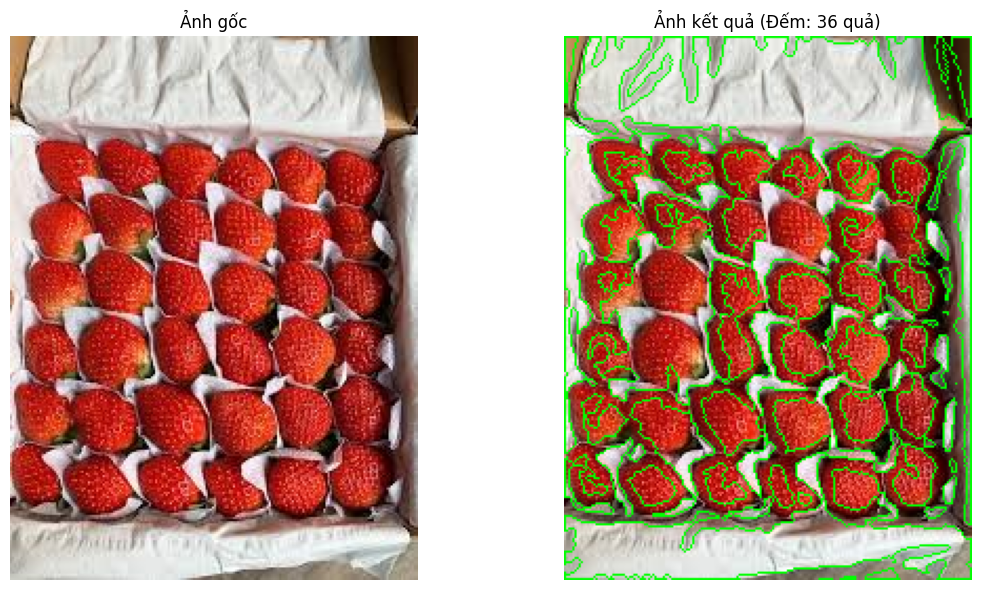

In [ ]:
imgd= cv2.imread("/content/drive/MyDrive/Colab Notebooks/dau.jpg" )
gray_d= cv2.cvtColor(imgd, cv2.COLOR_BGR2GRAY)
gray_d
blur= cv2.GaussianBlur(gray_d, (9,9), 0)
blur
bd = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# plt.imshow(bd, cmap='gray')
bd
contours, _ = cv2.findContours(bd, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 4. Vẽ contour lên ảnh gốc
anh_ket_qua = imgd.copy()
cv2.drawContours(anh_ket_qua, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(imgd, cv2.COLOR_BGR2RGB))
plt.title(f"Ảnh gốc")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(anh_ket_qua, cv2.COLOR_BGR2RGB))
plt.title(f"Ảnh kết quả (Đếm: {len(contours)} quả)")
plt.axis('off')

plt.tight_layout()
plt.show()
